In [1]:
import numpy as np
import astropy.units as u
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

In [67]:
data1 = Table.read('../data/data1.ecsv')
cluster1 = Table.read('../data/cluster1.ecsv')

In [3]:
# data0 = Table.read('../session_01/data0.ecsv')
# positive_parallaxes = data0['parallax'] > 0
# data1 = data0[positive_parallaxes]
# data1['mg'] = data1['phot_g_mean_mag']+5*np.log10(data1['parallax'])-10
# manual_filter1 = (data1['parallax'] > 5.0*u.mas) & (data1['parallax'] < 5.7*u.mas)
# cluster1 = data1[manual_filter1]

In [4]:
pos = np.vstack([data1['pmra'].data,
                 data1['pmdec'].data, 
                 data1['parallax'].data]).T
pos
np.shape(pos)

(21475, 3)

In [5]:
pos

array([[ -4.03323157,   2.91571593,   0.8287273 ],
       [ -2.60482938,  -2.79293561,   0.42735111],
       [ -1.74530183,  -6.23332145,   1.56167871],
       ...,
       [  4.7305853 ,  -0.40351734,   3.70439955],
       [ -1.48784179,  -2.22870356,   0.29063515],
       [ 14.64033053, -19.62141417,   1.46382344]])

## KMeans

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(pos)
labels = kmeans.predict(pos)


In [7]:
# Finding the final centroids
centroids = kmeans.cluster_centers_
centroids

array([[  7.4665085 , -33.8676799 ,   2.53025827],
       [ -2.18402592,  -4.20821427,   1.05809685],
       [-31.31618761, -15.66891184,   3.88921651]])

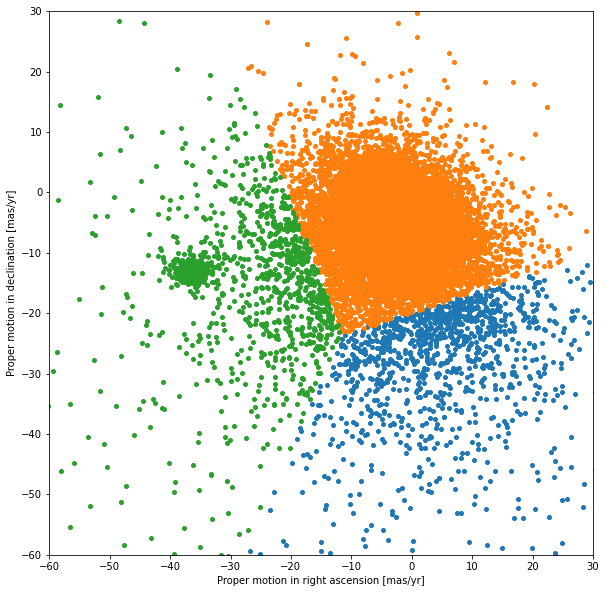

In [8]:
fig, ax = plt.subplots(ncols=1, figsize=(18,10))
ax.scatter(data1['pmra'], data1['pmdec'], c='gray', s=1, alpha=0.5);
for l in np.unique(labels):
    ax.plot(data1[labels==l]['pmra'], data1[labels==l]['pmdec'], marker='o', ls='', ms=4)

ax.set_aspect('equal')

ax.set_xlabel('Proper motion in right ascension [mas/yr]')
ax.set_ylabel('Proper motion in declination [mas/yr]')

ax.set_xlim(-60, 30)
ax.set_ylim(-60, 30);


Not really what we are looking for. It is purely forcing the groups to follow linear distance, without taking into consideration the density. We need to find an alternative method.

## DBSCAN

In [9]:
# from astropy.coordinates import Distance
# from sklearn.neighbors import DistanceMetric
# from sklearn.cluster import DBSCAN

# def get_clusters(pos,eps=.005,min_samples=20,sphere=False):   
#     if sphere:
#         print('Requiring that there are {:d} neighbors in a {:.1f} degree radius '.format(min_samples, np.rad2deg(eps)))
#         print('Using haversine 2D distance on sky')
#         dist= DistanceMetric.get_metric('haversine').pairwise(pos[:,:2])
#     else:
#         print('Requiring that there are {:d} neighbors in a {:.1f} pc radius '.format(min_samples, eps*1e3))
#         print('Using Euclidean 3D distance')
#         dist= DistanceMetric.get_metric('euclidean').pairwise(pos)
#     db = DBSCAN(eps=eps, min_samples=min_samples,metric='precomputed').fit(dist)
#     core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#     core_samples_mask[db.core_sample_indices_] = True
#     labels = db.labels_

#     # Number of clusters in labels, ignoring noise if present.
#     n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#     print('Clusters {0}'.format(n_clusters_))
#     return labels,core_samples_mask, n_clusters_

In [10]:
from astropy.coordinates import Distance
from sklearn.neighbors import DistanceMetric
from sklearn.cluster import DBSCAN

def get_clusters(pos, eps=.005, min_samples=20,sphere=False):   
    db = DBSCAN(eps=eps, min_samples=min_samples,metric='euclidean').fit(pos)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print('Clusters {0}'.format(n_clusters))
    return labels,core_samples_mask, n_clusters

In [11]:
labels, core_samples_mask, n_clusters = get_clusters(pos, eps=2, min_samples=25, sphere=False)

Clusters 3


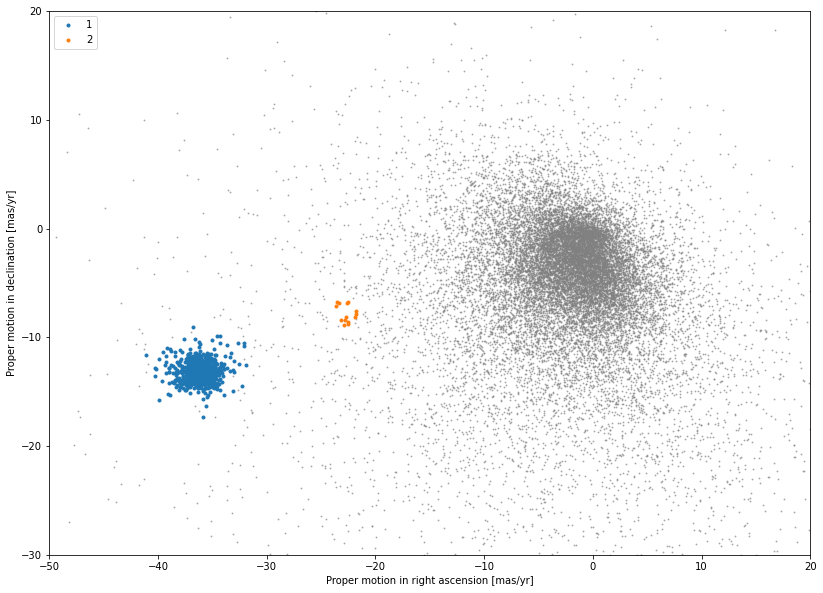

In [12]:
fig, ax = plt.subplots(ncols=1, figsize=(18,10))
ax.scatter(data1['pmra'], data1['pmdec'], c='gray', s=1, alpha=0.5);

for l in set(labels):
    if l > 0:
        ax.plot(data1[labels==l]['pmra'],
                data1[labels==l]['pmdec'],
                marker='o', ls='', ms=3, label=l)

ax.set_aspect('equal')

ax.set_xlabel('Proper motion in right ascension [mas/yr]')
ax.set_ylabel('Proper motion in declination [mas/yr]')

ax.set_xlim(-50, 20)
ax.set_ylim(-30, 20);

ax.legend()

TBD

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


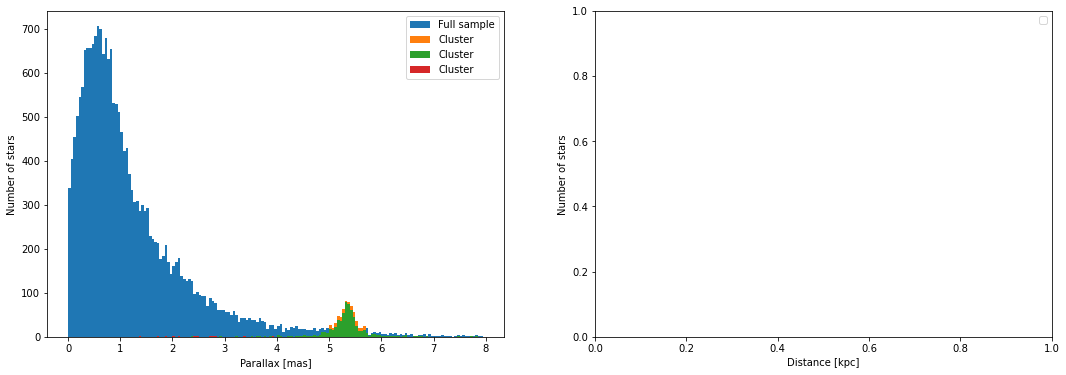

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(18,6))
ax[0].hist(data1['parallax'],    bins=np.arange(0, 8, 0.05), label='Full sample')
ax[0].hist(cluster1['parallax'], bins=np.arange(0, 8, 0.05), label='Cluster')

#ax[1].hist(data1['distance'],    bins=np.arange(0, 2, 0.01), label='Full sample')
#ax[1].hist(cluster1['distance'], bins=np.arange(0, 2, 0.01), label='Cluster')

for l in set(labels):
    if l > 0:
        ax[0].hist(data1[labels==l]['parallax'], bins=np.arange(0, 8, 0.05), label='Cluster')
        
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Parallax [mas]')
ax[0].set_ylabel('Number of stars');
ax[1].set_xlabel('Distance [kpc]')
ax[1].set_ylabel('Number of stars');

ax[0].legend()
ax[1].legend();

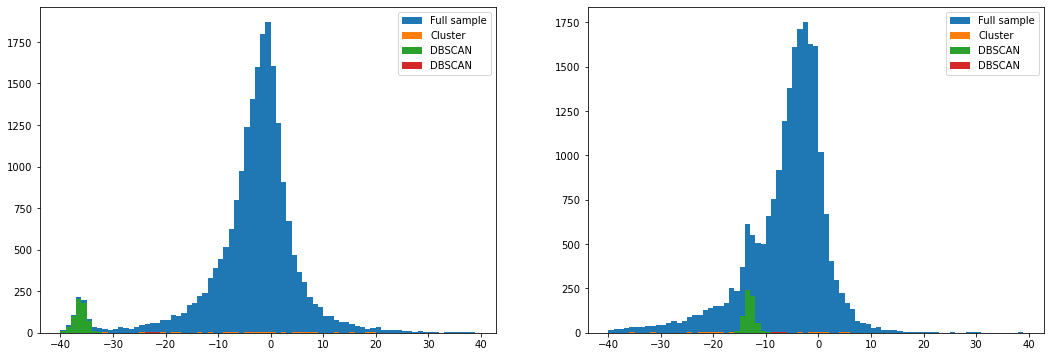

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(18,6))
ax[0].hist(data1['pmra'],    bins=np.arange(-40, 40, 1), label='Full sample')
ax[0].hist(cluster1['pmra'], bins=np.arange(-40, 40, 1), label='Cluster')

ax[1].hist(data1['pmdec'],    bins=np.arange(-40, 40, 1), label='Full sample')
ax[1].hist(cluster1['pmdec'], bins=np.arange(-40, 40, 1), label='Cluster')

for l in set(labels):
    if l > 0:
        ax[0].hist(data1[labels==l]['pmra'], bins=np.arange(-40, 40, 1), label='DBSCAN')
        ax[1].hist(data1[labels==l]['pmdec'], bins=np.arange(-40, 40, 1), label='DBSCAN')

        
ax[0].legend()
ax[1].legend()

ax[0].legend()
ax[1].legend();

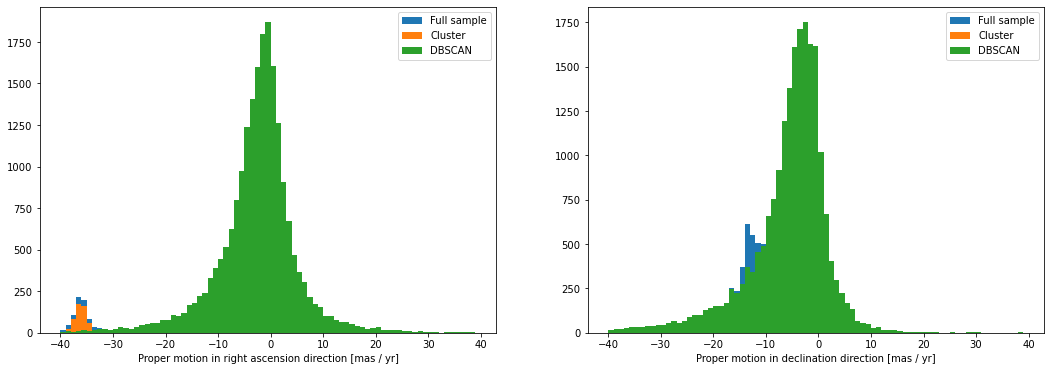

In [48]:
fig, ax = plt.subplots(ncols=2, figsize=(18,6))
ax[0].hist(data1['pmra'],    bins=np.arange(-40, 40, 1), label='Full sample')
ax[0].hist(cluster1['pmra'], bins=np.arange(-40, 40, 1), label='Cluster')

ax[1].hist(data1['pmdec'],    bins=np.arange(-40, 40, 1), label='Full sample')
ax[1].hist(cluster1['pmdec'], bins=np.arange(-40, 40, 1), label='Cluster')

ax[0].hist(data1[labels!=1]['pmra'],  bins=np.arange(-40, 40, 1), label='DBSCAN')
ax[1].hist(data1[labels!=1]['pmdec'], bins=np.arange(-40, 40, 1), label='DBSCAN')

def str_label(tab, col):
    return f"{tab[col].description} [{tab[col].quantity.unit}]"

ax[0].set_xlabel(str_label(data1, 'pmra'))
ax[1].set_xlabel(str_label(data1, 'pmdec'))


ax[0].legend()
ax[1].legend()

ax[0].legend()
ax[1].legend();

In [69]:
cluster2 = data1[labels==1]
cluster2.write('../data/cluster2.ecsv', format='ascii.ecsv', overwrite=True)

## Photometry

In [17]:
cluster1.columns

<TableColumns names=('dist','solution_id','DESIGNATION','source_id','random_index','ref_epoch','ra','ra_error','dec','dec_error','parallax','parallax_error','parallax_over_error','pmra','pmra_error','pmdec','pmdec_error','ra_dec_corr','ra_parallax_corr','ra_pmra_corr','ra_pmdec_corr','dec_parallax_corr','dec_pmra_corr','dec_pmdec_corr','parallax_pmra_corr','parallax_pmdec_corr','pmra_pmdec_corr','astrometric_n_obs_al','astrometric_n_obs_ac','astrometric_n_good_obs_al','astrometric_n_bad_obs_al','astrometric_gof_al','astrometric_chi2_al','astrometric_excess_noise','astrometric_excess_noise_sig','astrometric_params_solved','astrometric_primary_flag','astrometric_weight_al','astrometric_pseudo_colour','astrometric_pseudo_colour_error','mean_varpi_factor_al','astrometric_matched_observations','visibility_periods_used','astrometric_sigma5d_max','frame_rotator_object_type','matched_observations','duplicated_source','phot_g_n_obs','phot_g_mean_flux','phot_g_mean_flux_error','phot_g_mean_flux_

(15.0, -2.5)

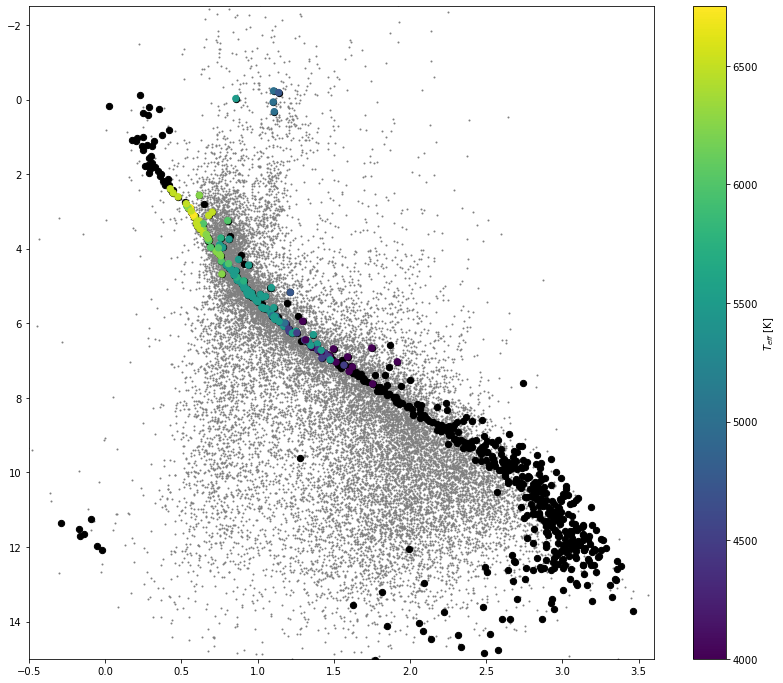

In [18]:
fig, ax = plt.subplots(ncols=1, figsize=(14,12))
ax.scatter(data1['bp_rp'], data1['Mg'], c='grey', s=1)
ax.scatter(cluster2['bp_rp'], cluster2['Mg'], c='k', s=40)
l = plt.scatter(cluster2['bp_rp'], cluster2['Mg'], c=cluster2['rv_template_teff'], s=40)

#ax.set_xlabel('G-RP colour. 630-1050nm')
#ax.set_ylabel('G-band mean magnitude')
ax.invert_yaxis()

cb = fig.colorbar(l)
cb.set_label("$T_{eff}$ [K]")

ax.set_xlim(-0.5, 3.6)
ax.set_ylim(15, -2.5)

In [50]:
import os
if not os.path.isfile('read_mist_models.py'):
    os.system("https://raw.githubusercontent.com/jieunchoi/MIST_codes/master/scripts/read_mist_models.py")

In [20]:
import read_mist_models

In [92]:
filename = '../data/MIST_iso_62321da9c816b.iso.cmd'

if not os.path.isfile(filename):
    os.system("cd ../data && unzip MIST_isocmd.zip")

isocmd = read_mist_models.ISOCMD(filename)

Reading in: ../data/MIST_iso_62321da9c816b.iso.cmd


In [22]:
print('version: ', isocmd.version)
print('abundances: ', isocmd.abun)
print('rotation: ', isocmd.rot)
print('ages: ', [round(x,2) for x in isocmd.ages])
print('number of ages: ', isocmd.num_ages)
print('available columns: ', isocmd.hdr_list)

version:  {'MIST': '1.2', 'MESA': '7503'}
abundances:  {'Yinit': 0.2703, 'Zinit': 0.0142, '[Fe/H]': 0.0, '[a/Fe]': 0.0}
rotation:  0.4
ages:  [5.0, 5.05, 5.1, 5.15, 5.2, 5.25, 5.3, 5.35, 5.4, 5.45, 5.5, 5.55, 5.6, 5.65, 5.7, 5.75, 5.8, 5.85, 5.9, 5.95, 6.0, 6.05, 6.1, 6.15, 6.2, 6.25, 6.3, 6.35, 6.4, 6.45, 6.5, 6.55, 6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05, 7.1, 7.15, 7.2, 7.25, 7.3, 7.35, 7.4, 7.45, 7.5, 7.55, 7.6, 7.65, 7.7, 7.75, 7.8, 7.85, 7.9, 7.95, 8.0, 8.05, 8.1, 8.15, 8.2, 8.25, 8.3, 8.35, 8.4, 8.45, 8.5, 8.55, 8.6, 8.65, 8.7, 8.75, 8.8, 8.85, 8.9, 8.95, 9.0, 9.05, 9.1, 9.15, 9.2, 9.25, 9.3, 9.35, 9.4, 9.45, 9.5, 9.55, 9.6, 9.65, 9.7, 9.75, 9.8, 9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25, 10.3]
number of ages:  107
available columns:  ['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kep

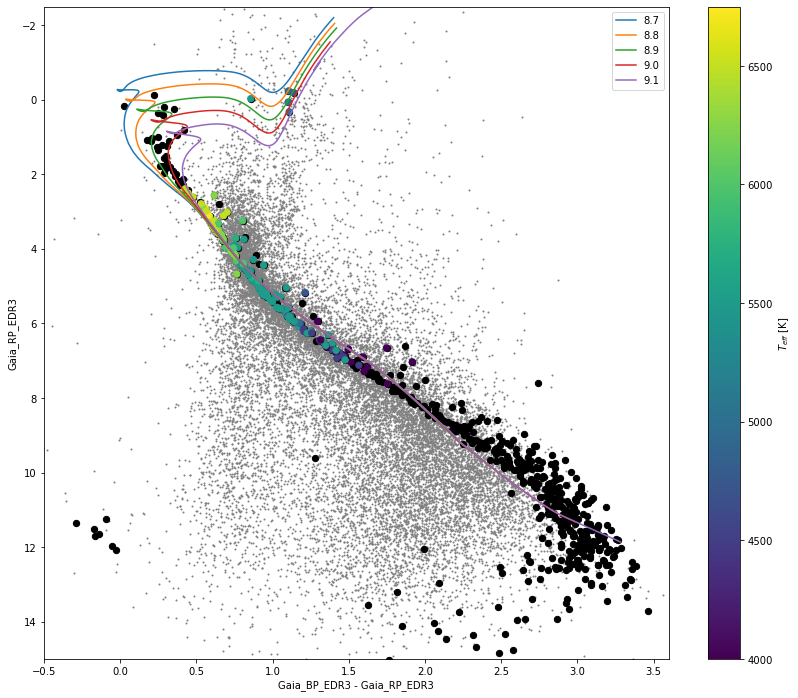

In [25]:
fig, ax = plt.subplots(ncols=1, figsize=(14,12))
ax.scatter(data1['bp_rp'], data1['Mg'], c='grey', s=1)
ax.scatter(cluster2['bp_rp'], cluster2['Mg'], c='k', s=40)
l = plt.scatter(cluster2['bp_rp'], cluster2['Mg'], c=cluster2['rv_template_teff'], s=40)

#ax.set_xlabel('G-RP colour. 630-1050nm')
#ax.set_ylabel('G-band mean magnitude')
ax.invert_yaxis()

cb = fig.colorbar(l)
cb.set_label("$T_{eff}$ [K]")

ax.set_xlim(-0.5, 3.6)
ax.set_ylim(15, -2.5)

# We can use phase to select the part of the isochrone for stars in the main sequence and red giant phases.
phase_mask = (isocmd.isocmds[0]['phase'] >= 0) & (isocmd.isocmds[0]['phase'] < 3)

for age in [8.7, 8.8, 8.9, 9.0, 9.1]:
    age_ind = isocmd.age_index(age) #returns the index for the desired age
    phase_mask = (isocmd.isocmds[age_ind]['phase'] >= 0) & (isocmd.isocmds[age_ind]['phase'] < 3)
    BP = isocmd.isocmds[age_ind]['Gaia_BP_EDR3'][phase_mask]
    RP = isocmd.isocmds[age_ind]['Gaia_RP_EDR3'][phase_mask]
    ax.plot(BP-RP, RP, label=age) 

ax.set_xlabel('Gaia_BP_EDR3 - Gaia_RP_EDR3')
ax.set_ylabel('Gaia_RP_EDR3')

ax.legend()

In [88]:
df = cluster2.to_pandas()
print('Average values for the cluter:')
print('Number of members  : {0}'.format(len(cluster2)))
print('Right Ascension    : {0:7.3f} {1}'.format(cluster2['ra'].mean(), cluster2['ra'].quantity.unit))
print('Declination        : {0:7.3f} {1}'.format(cluster2['dec'].mean(), cluster2['ra'].quantity.unit))
print('Proper motion R.A. : {0:7.2f} {1}'.format(cluster2['pmra'].mean(), cluster2['pmra'].quantity.unit))
print('Proper motion Dec. : {0:7.2f} {1}'.format(cluster2['pmdec'].mean(), cluster2['pmdec'].quantity.unit))
print('Distance           : {0:7.3f} {1}'.format(cluster2['distance'].mean(), cluster2['distance'].quantity.unit))

Average values for the cluter:
Number of members  : 631
Right Ascension    : 130.036 deg
Declination        :  19.855 deg
Proper motion R.A. :  -36.21 mas / yr
Proper motion Dec. :  -13.10 mas / yr
Distance           :   0.190 kpc


### ⛏ Exercise
Compare those values with the ones in Vizier table: J/A+A/633/A99/table1 Two options:  
(a) Download the Vizier table with `astroquery` as explained the first day  
(b) Simply visit https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ6232587c2323a1&-out.add=.&-source=J/A%2bA/633/A99/table1&recno=834

What is our discrepancy in the distance of the cluster with respect to that publication?

### 🌪 Exercise
Try to improve the proper motion of the cluster by computing the weighted average of the `pmra` and `pmdec` columns. You can do it by converting the column to a numpy array with the `.data` attribute, and then applying `np.average`. Check the documentation.

### 🌪 Exercise
The [Simbad page for NGC 2632 / M44](https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=m44) indicates that:

> Angular size (arcmin): 	118.2 118.2 0 (Opt) D [2020A&A...633A..99C ](https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2020A%26A...633A..99C)

Compute the physical size of `cluster2`